## Семинар 7: "Методы оптимизации"

ФИО: Вахрушев Вадим Юрьевич

In [2]:


import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
import abc
import seaborn as sns
from torchvision import transforms as tsf
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from tqdm import tqdm
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D



На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [3]:
import abc

class Optimizer(abc.ABC):
    def __init__(self, list_params):
        self.params = list(list_params)
  
    def step(self, err):
        pass

    def finish(self):
        with torch.no_grad():
            for param in self.params:
                param.grad.data.zero_()

class GD(Optimizer):
    def __init__(self, list_params, learning_rate):
        super().__init__(list_params)
        self.learning_rate = learning_rate

    def step(self, err):
        loss = err()
        loss.backward()
        with torch.no_grad():
            for param in self.params:
                param -= self.learning_rate * param.grad
        self.finish()

class Momentum(GD):
    def __init__(self, list_params, learning_rate, nu=0.1):
        super().__init__(list_params, learning_rate)
        self.nu = nu
        self.vs = [torch.zeros_like(param) for param in self.params]

    def step(self, err):
        loss = err()
        loss.backward()
        with torch.no_grad():
            for v, param in zip(self.vs, self.params):
                v.copy_(self.nu * v + self.learning_rate * param.grad)                
                param -= v
        self.finish()

class NAG(GD):
    def __init__(self, list_params, learning_rate, nu=0.1):
        super().__init__(list_params, learning_rate)
        self.nu = nu
        self.vs = [torch.zeros_like(param) for param in self.params]

    def step(self, err):
        with torch.no_grad():
            for v, param in zip(self.vs, self.params):
                param -= self.nu * v
        loss = err()
        loss.backward()
        with torch.no_grad():
            for v, param in zip(self.vs, self.params):
                param += self.nu * v
                v.copy_(self.nu * v + self.learning_rate * param.grad)        
                param -= v
        self.finish()

class RMSProp(GD):
    def __init__(self, list_params, learning_rate, gamma=0.9):
        super().__init__(list_params, learning_rate)
        self.gamma = gamma
        self.g_sq_list = [torch.zeros_like(param) for param in self.params]
        self.eps = 10 ** -8

    def step(self, err):
        loss = err()
        loss.backward()
        with torch.no_grad():
              for g_sq, param in zip(self.g_sq_list, self.params):
                g_sq.copy_(self.gamma * g_sq + (1 - self.gamma) * param.grad ** 2)
                param -= self.learning_rate * param.grad / (g_sq + self.eps) ** 0.5
        self.finish()



class AdaDelta(Optimizer):
    def __init__(self, list_params, learning_rate, gamma=0.9):
        super().__init__(list_params)
        self.gamma = gamma
        self.D_t = [torch.zeros_like(param) for param in self.params]
        self.prev_params = [torch.zeros_like(param) for param in self.params]
        self.g_sq_list = [torch.zeros_like(param) for param in self.params]
        self.eps = 10 ** -8

    def step(self, err):
        loss = err()
        loss.backward()
        with torch.no_grad():
            for g_sq, d_t, prev_param, param in zip(self.g_sq_list, self.D_t, self.prev_params, self.params):
                g_sq.copy_(self.gamma * g_sq + (1 - self.gamma) * param.grad ** 2)
                d_t.copy_(self.gamma * d_t + (1 - self.gamma)
                          * (param - prev_param) ** 2)
                prev_param.copy_(param)
                delta = ((d_t + self.eps) / (g_sq + self.eps)) ** 0.5 * param.grad 
                param -= delta
        self.finish()


class Adagrad(GD):
    def __init__(self, list_params, learning_rate):
        super().__init__(list_params, learning_rate)
        self.g_sq_list = [torch.zeros_like(param) for param in self.params]
        self.eps = 10 ** -8

    def step(self, err):
        loss = err()
        loss.backward()
        with torch.no_grad():
              for g_sq, param in zip(self.g_sq_list, self.params):
                g_sq += param.grad ** 2
                param -= self.learning_rate * param.grad / (g_sq + self.eps) ** 0.5
        self.finish()
        
class Adam(GD):
    def __init__(self, list_params, learning_rate):
        super().__init__(list_params, learning_rate)
        self.m_list = [torch.zeros_like(param) for param in self.params]
        self.nu_list = [torch.zeros_like(param) for param in self.params]
        self.eps = 10 ** -8
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.iter = 0

    def step(self, err):
        loss = err()
        loss.backward()
        with torch.no_grad():
            self.iter += 1
            for m, nu, param in zip(self.m_list, self.nu_list, self.params):
                m.copy_(self.beta1 * m + (1 - self.beta1) * param.grad)
                nu.copy_(self.beta2 * nu + (1 - self.beta2) * param.grad ** 2)
                param -= (self.learning_rate * m / (1 - self.beta1 ** self.iter)
                          / (nu / (1 - self.beta2 ** self.iter) + self.eps) ** 0.5)
        self.finish()

In [4]:
def make_var(x):
    x = np.array([float(x)])
    x = torch.from_numpy(x)
    return torch.autograd.Variable(x, requires_grad=True)

learning_rate = 0.001

In [5]:
def J(x, y):
    return x**2 + y**2

def J(x, y):
    if isinstance(x, np.ndarray):
        return x**2 * np.sin(x) + y**2 * np.sin(y)
    else:
        return x**2 * x.sin() + y**2 * y.sin()

"""
def J(x, y):
  return x**2 - y**2
"""

def J(x, y):
    if isinstance(x, np.ndarray):
        return x**2 * np.sin(x**2) + y**2 * np.sin(y**2)
    else:
        return x**2 * ((x**2).sin()) + y**2 * ((y**2).sin())

In [6]:
def make_var(x):
    x = np.array([float(x)])
    x = torch.from_numpy(x)
    return torch.autograd.Variable(x, requires_grad=True)

x, y = make_var(1), make_var(2)

def err(J=J, x=x, y=y):
    return J(x, y)

learning_rate = 0.00001

optimizers = [
  GD([x, y], learning_rate),
  Momentum([x, y], learning_rate),
  NAG([x, y], learning_rate),
  RMSProp([x, y], learning_rate),
]

all_points = []

for optim in optimizers:
    with torch.no_grad():
        x.copy_(torch.tensor(-6.0))
        y.copy_(torch.tensor(2))

    points = []

    for i in range(200):
        points.append((x.item(), y.item()))
        optim.step(err)
    #points.append((x.item(), y.item()))

    print(err())

    points = np.array(points)
    all_points.append(points)

tensor([-39.5162], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-39.5523], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-39.5523], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([-38.8879], dtype=torch.float64, grad_fn=<AddBackward0>)


##### <i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [6]:
def J(x, y):
    return x**2 + y**2

In [7]:
def create_points(optim, J, n):    
    points = []

    for i in range(n):
        points.append((X.item(), Y.item(), J().item()))
        optim.step(J)

    points = np.array(points)
    return points

In [8]:
names = ['GD','Momentum', 'NAG', 'Adagrad','AdaDelta','Adam']

GD : 1.5709099088952725e-89
Momentum : 1.5709099088952725e-89
NAG : 1.5709099088952725e-89
Adagrad : 3.441640865081075
AdaDelta : 0.0
Adam : 8.649599436795058e-30


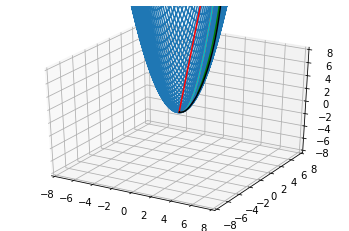

In [12]:


optims = [lambda v: GD(v, 0.1), lambda v: Momentum(v, 0.1), lambda v: NAG(v, 0.1), 
          lambda v: Adagrad(v, 0.1), lambda v: AdaDelta(v, 0.1), lambda v: Adam(v, 0.1)]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

size = 8
X = np.linspace(-size, size, 100)
Y = np.linspace(-size, size, 100)

ax.set_xlim3d(-size, size)
ax.set_ylim3d(-size, size)
ax.set_zlim3d(-size, size)

xx, yy = np.meshgrid(X, Y)
Z = J(xx, yy)

ax.plot(xx.flatten(), yy.flatten(), Z.flatten())

c = ['y', 'm', 'c', 'g', 'r', 'k']
i = 0
for optim in optims:
    X = torch.tensor(6.0, requires_grad=True)
    Y = torch.tensor(-2.0, requires_grad=True)    
    
    points = create_points(optim([X, Y]), lambda X=X, Y=Y: J(X, Y), 700)

    ax.plot(points[:, 0], points[:, 1], points[:, 2], c=c[i])
    print(names[i],':',J(points[-1, 0], points[-1, 1]))
    i += 1
plt.show()



<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [14]:
def J(x, y):
    return x**2 *x.sin() + y**2*y.sin()

GD : -28.008032
Momentum : -21.168943
NAG : -15.803862
Adagrad : -28.028261
AdaDelta : -3.639967
Adam : -28.028261


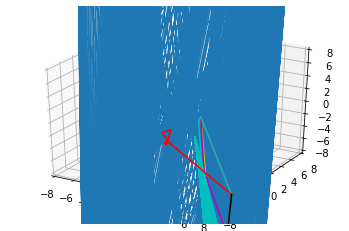

In [24]:
optims = [lambda v: GD(v, 0.1), lambda v: Momentum(v, 0.1), lambda v: NAG(v, 0.1), 
          lambda v: Adagrad(v, 0.1), lambda v: AdaDelta(v, 0.1), lambda v: Adam(v, 0.1)]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

size = 8
X = np.linspace(-size, size, 100)
Y = np.linspace(-size, size, 100)

ax.set_xlim3d(-size, size)
ax.set_ylim3d(-size, size)
ax.set_zlim3d(-size, size)

xx, yy = np.meshgrid(X, Y)
Z = J(torch.FloatTensor(xx), torch.FloatTensor(yy))

ax.plot(xx.flatten(), yy.flatten(), Z.flatten())

c = ['y', 'm', 'c', 'g', 'r', 'k']
i = 0
for optim in optims:
    X = torch.tensor(6.0, requires_grad=True)
    Y = torch.tensor(-1.0, requires_grad=True)    
    
    points = create_points(optim([X, Y]), lambda X=X, Y=Y: J(X, Y), 700)

    ax.plot(points[:, 0], points[:, 1], points[:, 2], c=c[i])
    print(names[i],':',J(torch.FloatTensor([points[-1, 0]]), \
                         torch.FloatTensor([points[-1, 1]])).numpy()[0])

    i += 1
plt.show()


<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [25]:
def J(x, y):
    return x**2 *(x ** 2).sin() + y**2*(y **2).sin()

GD : -4.8144493
Momentum : 7.4261276e-05
NAG : -4.814451
Adagrad : -36.142147
AdaDelta : -11.001795
Adam : -36.142147


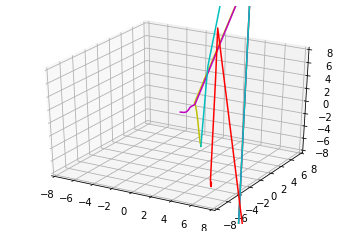

In [31]:
optims = [lambda v: GD(v, 0.01), lambda v: Momentum(v, 0.01), lambda v: NAG(v, 0.01), 
          lambda v: Adagrad(v, 0.01), lambda v: AdaDelta(v, 0.01), lambda v: Adam(v, 0.01)]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

size = 8
X = np.linspace(-size, size, 100)
Y = np.linspace(-size, size, 100)

ax.set_xlim3d(-size, size)
ax.set_ylim3d(-size, size)
ax.set_zlim3d(-size, size)

xx, yy = np.meshgrid(X, Y)
Z = J(torch.FloatTensor(xx), torch.FloatTensor(yy))


c = ['y', 'm', 'c', 'g', 'r', 'k']
i = 0
for optim in optims:
    X = torch.tensor(6.0, requires_grad=True)
    Y = torch.tensor(0.1, requires_grad=True)    
    
    points = create_points(optim([X, Y]), lambda X=X, Y=Y: J(X, Y), 1500)

    ax.plot(points[:, 0], points[:, 1], points[:, 2], c=c[i])
    print(names[i],':',J(torch.FloatTensor([points[-3, 0]]), \
                         torch.FloatTensor([points[-1, 1]])).numpy()[0])
    i += 1
plt.show()

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [11]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision import transforms
from tqdm import tqdm

In [12]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
dataset = datasets.MNIST(download=True, train=True, root='./data', transform=transform)
dataloader = DataLoader(dataset, shuffle=True, batch_size=32)
epoch=10

In [58]:
linear = nn.Sequential(nn.Linear(28*28, 128), nn.Linear(128, 10), nn.LogSoftmax())

loss_func = nn.NLLLoss()
adam = Adam(linear.parameters(), learning_rate=0.001)
adagrad = Adagrad(linear.parameters(), learning_rate=0.001)
adadelta = AdaDelta(linear.parameters(), learning_rate=0.001)
sgd = GD(linear.parameters(), learning_rate=0.001)

In [8]:
def compare_optim(optim, epoch, model, loss_function):
    epoch_losses = []
    for i in tqdm(range(epoch)):
        losses = []
        for x, y in dataloader:
            model.zero_grad()
            x = x.view(-1, 784)
            y_pred = model(x)
            loss = loss_function(y_pred, y)
            def err(J=loss_function, x=y_pred, y=y):
                return J(x, y)
            optim.step(err)
            losses.append(np.array(loss.cpu().data))
        epoch_losses.append(np.mean(losses))
    return epoch_losses

In [60]:
adadelta_loss = compare_optim(adadelta, epoch, linear, loss_func)
adam_loss = compare_optim(adam, epoch, linear, loss_func)
adagrad_loss = compare_optim(adagrad, epoch, linear, loss_func)
gd_loss = compare_optim(sgd, epoch, linear, loss_func)




  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:20<03:08, 20.96s/it]

 20%|██        | 2/10 [00:42<02:49, 21.13s/it]

 30%|███       | 3/10 [01:08<02:38, 22.66s/it]

 40%|████      | 4/10 [01:30<02:13, 22.25s/it]

 50%|█████     | 5/10 [01:52<01:51, 22.25s/it]

 60%|██████    | 6/10 [02:11<01:24, 21.22s/it]

 70%|███████   | 7/10 [02:28<01:00, 20.06s/it]

 80%|████████  | 8/10 [02:50<00:41, 20.65s/it]

 90%|█████████ | 9/10 [03:08<00:19, 19.73s/it]

100%|██████████| 10/10 [03:26<00:00, 20.69s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:19<02:58, 19.82s/it]

 20%|██        | 2/10 [00:40<02:41, 20.21s/it]

 30%|███       | 3/10 [00:57<02:14, 19.27s/it]

 40%|████      | 4/10 [01:15<01:52, 18.70s/it]

 50%|█████     | 5/10 [01:36<01:36, 19.39s/it]

 60%|██████    | 6/10 [01:53<01:14, 18.69s/it]

 70%|███████   | 7/10 [02:12<00:56, 18.79s/it]

 80%|████████  | 8/10 [02:30<00:37, 18.57s/it]

 90%|█████████ | 9/10 [02:46<00:17, 17.85s/it]

100%

No handles with labels found to put in legend.


Text(0.5, 1.0, 'SGD')

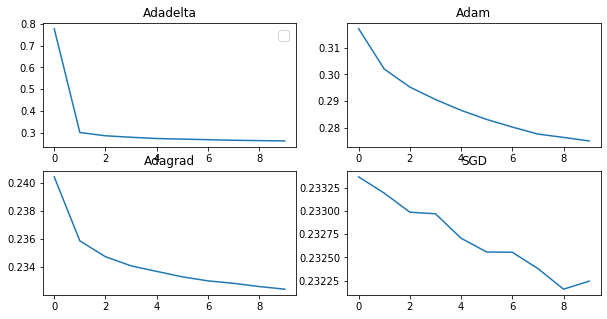

In [61]:


fig = plt.figure(figsize=(10,5))

fig.add_subplot(222)
plt.plot(adam_loss)
plt.title("Adam")

fig.add_subplot(221)
plt.plot(adadelta_loss)
plt.legend(loc=1, fontsize=14)
plt.title("Adadelta")

fig.add_subplot(223)
plt.plot(adagrad_loss)
plt.title("Adagrad")

fig.add_subplot(224)
plt.plot(gd_loss)
plt.title("SGD")



<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [13]:
image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 3, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*3, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    
conv = ConvClassifier(image_size=28)


loss_func = nn.NLLLoss()
adam = Adam(conv.parameters(), learning_rate=0.001)
adagrad = Adagrad(conv.parameters(), learning_rate=0.001)
adadelta = AdaDelta(conv.parameters(), learning_rate=0.001)
sgd = GD(conv.parameters(), learning_rate=0.001)

In [14]:
adam_loss = compare_optim(adam, epoch, conv, loss_func)
adagrad_loss = compare_optim(adagrad, epoch, conv, loss_func)
adadelta_loss = compare_optim(adadelta, epoch, conv, loss_func)
gd_loss = compare_optim(sgd, epoch, conv, loss_func)


100%|██████████| 10/10 [03:23<00:00, 20.38s/it]


No handles with labels found to put in legend.


Text(0.5, 1.0, 'GD')

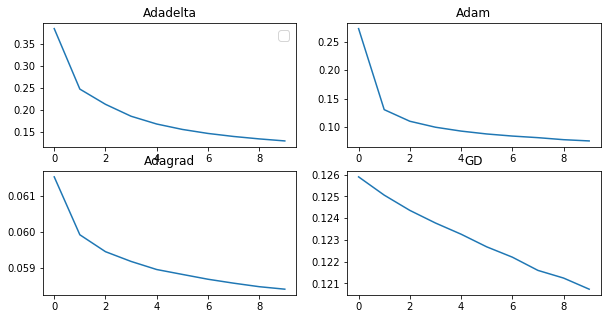

In [16]:


fig = plt.figure(figsize=(10,5))

fig.add_subplot(222)
plt.plot(adam_loss)
plt.title("Adam")

fig.add_subplot(221)
plt.plot(adadelta_loss)
plt.legend(loc=1, fontsize=14)
plt.title("Adadelta")

fig.add_subplot(223)
plt.plot(adagrad_loss)
plt.title("Adagrad")

fig.add_subplot(224)
plt.plot(gd_loss)
plt.title("GD")

Можно сделать вывод, что при тестировании полносвязной сети лучше всего показал себя GD, чуть хуже - Adagrad и еще хуже Adam и Adadelta.
При тестировании сверточной сети Adagrad показал лучшие результаты, дальше идут GD, Adam и Adadelta. Скорее всего, результаты оптимизаторов зависят от параметра learinig_rate и архитектуры сети

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: